In [35]:
import numpy as np
import pandas as pd
import random

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from gwo import GreyWolfOptimizer
from sklearn.metrics import log_loss, roc_auc_score

from numba import njit


In [36]:
trainValData = pd.read_csv("../dataset/train_val.data")
testData = pd.read_csv("../dataset/test.data")

X_trainVal = trainValData.drop(columns=["Diagnosis"])
y_trainVal = trainValData["Diagnosis"]

X_test = testData.drop(columns=["Diagnosis"])
y_test = testData["Diagnosis"]


In [37]:
X_train, X_val, y_train, y_val = train_test_split(
    X_trainVal,
    y_trainVal,
    test_size=0.2,
    random_state=1,
    stratify=y_trainVal
)

In [38]:
baselineModel = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric="logloss",
    random_state=1
)

baselineModel.fit(X_trainVal, y_trainVal)

y_pred_baseline = baselineModel.predict(X_test)

baselineResults = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline)
}

baselineResults


{'Accuracy': 0.9649122807017544,
 'Precision': 0.9523809523809523,
 'Recall': 0.9523809523809523,
 'F1': 0.9523809523809523}

In [39]:
def xgboostObjectiveFunction(position):
    n_estimators = int(position[0])
    max_depth = int(position[1])
    learning_rate = position[2]
    subsample = position[3]
    colsample_bytree = position[4]

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eval_metric="logloss",
        random_state=1
    )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fitness = log_loss(y_val, y_pred_proba) + (1 - roc_auc_score(y_val, y_pred_proba))*0.1
    return fitness

Iterasi 1/50 | Best Fitness: 0.043819
Iterasi 2/50 | Best Fitness: 0.043819
Iterasi 3/50 | Best Fitness: 0.043819
Iterasi 4/50 | Best Fitness: 0.043819
Iterasi 5/50 | Best Fitness: 0.043819
Iterasi 6/50 | Best Fitness: 0.043819
Iterasi 7/50 | Best Fitness: 0.043819
Iterasi 8/50 | Best Fitness: 0.043819
Iterasi 9/50 | Best Fitness: 0.043819
Iterasi 10/50 | Best Fitness: 0.043819
Iterasi 11/50 | Best Fitness: 0.043819
Iterasi 12/50 | Best Fitness: 0.043799
Iterasi 13/50 | Best Fitness: 0.043799
Iterasi 14/50 | Best Fitness: 0.043799
Iterasi 15/50 | Best Fitness: 0.043799
Iterasi 16/50 | Best Fitness: 0.043799
Iterasi 17/50 | Best Fitness: 0.043799
Iterasi 18/50 | Best Fitness: 0.039495
Iterasi 19/50 | Best Fitness: 0.039495
Iterasi 20/50 | Best Fitness: 0.039495
Iterasi 21/50 | Best Fitness: 0.039495
Iterasi 22/50 | Best Fitness: 0.039495
Iterasi 23/50 | Best Fitness: 0.039495
Iterasi 24/50 | Best Fitness: 0.036814
Iterasi 25/50 | Best Fitness: 0.036814
Iterasi 26/50 | Best Fitness: 0.03

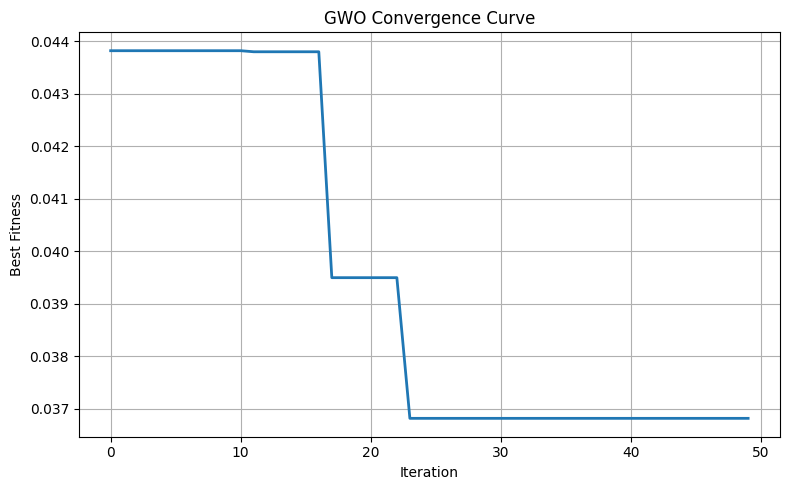


=== BEST PARAMETER FROM GWO ===
n_estimators : 135
max_depth   : 7
learning_rate: 0.24308067100900957
subsample : 0.8266195706042262
colsample_bytree : 0.8338790639358292


In [40]:
gwo = GreyWolfOptimizer(
    objectiveFunction=xgboostObjectiveFunction,
    lowerBound = [50, 2, 0.01, 0.6, 0.6],
    upperBound = [300, 8, 0.3, 1.0, 1.0],
    dimension=5
)

gwoResult = gwo.optimize()

bestParams = gwoResult["bestPosition"]

print("\n=== BEST PARAMETER FROM GWO ===")
print("n_estimators :", int(bestParams[0]))
print("max_depth   :", int(bestParams[1]))
print("learning_rate:", bestParams[2])
print("subsample :", bestParams[3])
print("colsample_bytree :", bestParams[4])

In [41]:
bestParamsDict = {
    "n_estimators": int(bestParams[0]),
    "max_depth": int(bestParams[1]),
    "learning_rate": bestParams[2],
    "subsample": bestParams[3],
    "colsample_bytree": bestParams[4]
}

bestParamsDict

{'n_estimators': 135,
 'max_depth': 7,
 'learning_rate': np.float64(0.24308067100900957),
 'subsample': np.float64(0.8266195706042262),
 'colsample_bytree': np.float64(0.8338790639358292)}

In [42]:
finalModel = XGBClassifier(
    n_estimators=bestParamsDict["n_estimators"],
    max_depth=bestParamsDict["max_depth"],
    learning_rate=bestParamsDict["learning_rate"],
    subsample=bestParamsDict["subsample"],
    colsample_bytree=bestParamsDict["colsample_bytree"],
    eval_metric="logloss",
    random_state=1
)

finalModel.fit(X_trainVal, y_trainVal)

y_pred_gwo = finalModel.predict(X_test)

gwoResults = {
    "Accuracy": accuracy_score(y_test, y_pred_gwo),
    "Precision": precision_score(y_test, y_pred_gwo),
    "Recall": recall_score(y_test, y_pred_gwo),
    "F1": f1_score(y_test, y_pred_gwo)
}

gwoResults

{'Accuracy': 0.9736842105263158,
 'Precision': 0.975609756097561,
 'Recall': 0.9523809523809523,
 'F1': 0.963855421686747}

In [43]:
comparison = pd.DataFrame(
    [baselineResults, gwoResults],
    index=["Baseline XGBoost", "XGBoost + AGWO"]
)

comparison

,Accuracy,Precision,Recall,F1
Baseline XGBoost,0.964912,0.952381,0.952381,0.952381
XGBoost + AGWO,0.973684,0.975610,0.952381,0.963855
